<a href="https://colab.research.google.com/github/geovalexis/TFG/blob/main/notebooks/machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Helper functions

In [3]:
import numpy as np
import pandas as pd

def filterOutByFrequency(column: pd.Series, min_threshold: int = None, max_threshold: int = None) -> pd.Series:
    col_exploded = column.explode()
    elements_counts = col_exploded.value_counts()
    print(f"The element with the maximum number of ocurrences is {elements_counts.idxmax()} with {elements_counts.max()} ocurrences.", flush=True)
    print(f"The element with the minimum number of ocurrences is {elements_counts.idxmin()} with {elements_counts.min()} ocurrences.", flush=True)
    min_threshold = min_threshold if min_threshold else elements_counts.min()
    max_threshold = max_threshold if max_threshold else elements_counts.max()
    out_elements = elements_counts[(elements_counts<min_threshold) | (elements_counts>max_threshold)].index
    column_filtered = col_exploded[~col_exploded.isin(out_elements)].dropna().groupby(level=list(range(column.index.nlevels))).agg(list)
    return column_filtered

In [129]:
# For translating the taxIDs to their corresponding complete names

!pip install ete3
from ete3 import NCBITaxa

def getSpeciesNames(taxa: list):
    ncbi = NCBITaxa()
    tax2names = ncbi.get_taxid_translator(taxa)
    #speciesNames = [tax2names[i] for i in taxa]
    return tax2names


     |████████████████████████████████| 4.7MB 4.3MB/s 
  Created wheel for ete3: filename=ete3-3.1.2-cp37-none-any.whl size=2272997 sha256=c642cc10708f8050e3362f75a6f1428f3e0b4db69ab947b32775cce33d2b20d6
  Stored in directory: /root/.cache/pip/wheels/22/37/14/723e53cc6295e9d3b83de0289a4666324ddebe8cbcb024a722
Successfully built ete3


In [128]:
def sort_by_evolutionary_distance(reference_tax, taxa: list):
    taxa_list = taxa
    if reference_tax not in taxa_list: # The reference_tax must among the taxa list
      taxa_list.append(reference_tax)  
    ncbi = NCBITaxa()
    phylogenetic_tree = ncbi.get_topology(taxa_list)
    reference_tax_node = phylogenetic_tree.search_nodes(name=str(reference_tax))[0]
    distance_matrix = []
    for tax in taxa:
        tax_node = phylogenetic_tree.search_nodes(name=str(tax))[0]
        dist = phylogenetic_tree.get_distance(reference_tax_node, tax_node) 
        distance_matrix.append((tax_node.name, dist))
    sorted_by_dist = sorted(distance_matrix, key=lambda tup: tup[1])
    return [int(tup[0]) for tup in sorted_by_dist]

### Parse Phylogenetic Profiling Matrix (with GO terms)

In [119]:
# Read PP matrix
import pandas as pd

profiling_matrix = pd.read_table("/content/drive/MyDrive/TFG/MtP_201601_blasted-all_proteins-pp_matrix_counts_with_taxa.tab", 
                                header=0, index_col=[0,1],  
                                converters={"GO_IDs": lambda x:  list(filter(None, x.split(",")))}) # if we don't filter there are no empty lists but lists with empty strings: [''] (its lenght is 1, not 0))
profiling_matrix

189518  ...                                             GO_IDs
9606   Q96T66       1  ...                           [GO:0009165, GO:0019674]
       Q6IQ20       1  ...  [GO:0001523, GO:0001659, GO:0048874, GO:005072...
       Q9H3J6       2  ...                                                 []
       Q14397       1  ...  [GO:0006110, GO:0006606, GO:0009750, GO:003313...
       Q8NFV4       1  ...                                                 []
...               ...  ...                                                ...
243274 Q9X0B7       0  ...                                                 []
       Q9X1T3       0  ...                                                 []
       Q9X2C2       0  ...                                                 []
       Q9X1M4       0  ...                                                 []
       Q9X043       0  ...                                                 []

[578869 rows x 79 columns]

In [120]:
# Filter out GO terms does not meet a certain number of ocurrences
profiling_matrix = profiling_matrix.assign(GO_IDs=filterOutByFrequency(profiling_matrix["GO_IDs"], min_threshold=100, max_threshold=None)).dropna()
profiling_matrix

The element with the maximum number of ocurrences is GO:0045944 with 2457 ocurrences.
The element with the minimum number of ocurrences is GO:1903925 with 1 ocurrences.


189518  85962  ...  7918                                GO_IDs
9606   Q6IQ20       1      0  ...     0                          [GO:0050729]
       Q14397       1      0  ...     0                          [GO:0006606]
       P00492       1      0  ...     0                          [GO:0051289]
       Q13751      12      0  ...     0              [GO:0008544, GO:0030198]
       P51160       1      0  ...     0                          [GO:0007601]
...               ...    ...  ...   ...                                   ...
83332  P9WQE1       0      0  ...     0                          [GO:0006633]
       P9WP15       0      0  ...     0                          [GO:0055114]
       P9WIH9       0      0  ...     0  [GO:0006402, GO:0017148, GO:0045892]
243274 Q9WYY1       1      0  ...     0                          [GO:0006281]
       Q9WZ31       1      0  ...     0                          [GO:0051260]

[47937 rows x 79 columns]

In [121]:
# Filter out unnotated proteins
profiling_matrix = profiling_matrix[profiling_matrix["GO_IDs"].str.len()>0]  # Drop those genes that do not have GO term (the final goal of the project is to assign them one, but to train the model we need to give it resolved examples)
profiling_matrix

189518  85962  ...  7918                                GO_IDs
9606   Q6IQ20       1      0  ...     0                          [GO:0050729]
       Q14397       1      0  ...     0                          [GO:0006606]
       P00492       1      0  ...     0                          [GO:0051289]
       Q13751      12      0  ...     0              [GO:0008544, GO:0030198]
       P51160       1      0  ...     0                          [GO:0007601]
...               ...    ...  ...   ...                                   ...
83332  P9WQE1       0      0  ...     0                          [GO:0006633]
       P9WP15       0      0  ...     0                          [GO:0055114]
       P9WIH9       0      0  ...     0  [GO:0006402, GO:0017148, GO:0045892]
243274 Q9WYY1       1      0  ...     0                          [GO:0006281]
       Q9WZ31       1      0  ...     0                          [GO:0051260]

[47937 rows x 79 columns]

In [103]:
go_terms_counts = profiling_matrix["GO_IDs"].explode().value_counts()
go_terms_counts[go_terms_counts>5000] #.iloc[-4:].index

GO:0008150    13000
GO:0009987    10903
GO:0065007     8692
GO:0050789     8228
GO:0050794     7695
GO:0008152     5880
GO:0071704     5570
GO:0044237     5453
GO:0044238     5099
Name: GO_IDs, dtype: int64

# GO terms distribution

## Matrix preparation

In [124]:
GO_terms = profiling_matrix["GO_IDs"].explode()
GO_terms.index.rename(["taxID","uniprotID"], inplace=True)
GO_terms = GO_terms.reset_index()
GO_terms_distribution = GO_terms.pivot_table(values="uniprotID", index="GO_IDs", columns="taxID", aggfunc="count", dropna=False, fill_value=0).astype(int)
GO_terms_distribution

taxID,3055,3702,4577,5664,5888,6239,6945,7070,7165,7227,7719,7739,7918,7955,8090,8364,9031,9595,9598,9606,9615,9913,10090,10116,13616,35128,36329,39947,44689,45351,64091,69014,83332,83333,85962,100226,122586,188937,189518,208964,214684,224308,224324,224911,226186,237561,237631,243230,243231,243232,243273,243274,273057,284591,284812,321614,330879,367110,436308,559292,665079,1111708
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000003,0,5,0,0,0,96,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:0000045,0,2,0,1,0,5,0,0,0,7,0,0,0,5,0,2,5,0,1,30,0,7,31,13,0,0,1,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,18,0,0
GO:0000070,0,4,0,0,0,23,0,0,0,20,0,0,0,4,0,0,1,0,0,16,0,1,12,5,0,0,3,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,34,0,0,0,0,18,0,0
GO:0000082,0,3,0,0,0,2,0,0,0,7,0,0,0,3,0,0,1,0,0,78,1,6,34,17,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,4,0,0,0,0,22,0,0
GO:0000086,0,3,0,0,0,0,0,0,0,6,0,0,0,3,0,0,4,0,0,117,2,5,24,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,20,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GO:1901215,0,0,0,0,0,8,0,0,0,9,0,0,0,1,1,0,0,0,0,34,0,2,19,49,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:1901796,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,125,0,0,7,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
GO:1902600,0,6,0,0,0,4,0,0,0,42,1,0,0,3,0,1,0,0,0,29,1,2,16,9,0,0,7,0,1,0,0,0,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,0,1,0,0,13,0,0


In [125]:
# Species without any GO term assigned
GO_terms_distribution.columns[GO_terms_distribution.mean()==0]

Int64Index([], dtype='int64', name='taxID')

## Matrix labeling and reordering

In [130]:
# Reordered by evolutionary distance 
GO_terms_distribution = GO_terms_distribution[sort_by_evolutionary_distance(9606, list(GO_terms_distribution.columns))]

NCBI database not present yet (first time used?)
Done. Parsing...


Loading node names...
2316619 names loaded.
243028 synonyms loaded.
Loading nodes...
2316619 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /root/.etetoolkit/taxa.sqlite ...
 2316000 generating entries... 

Inserting synonyms:      10000 


Uploading to /root/.etetoolkit/taxa.sqlite



Inserting synonyms:      240000 

Inserting taxids:       15000 

Inserting taxids:       2315000 

In [131]:
# Translate tax IDs to names
GO_terms_distribution = GO_terms_distribution.rename(columns=getSpeciesNames(list(GO_terms_distribution.columns)))


## Visualization

### Static Heat Map

/usr/local/lib/python3.7/dist-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


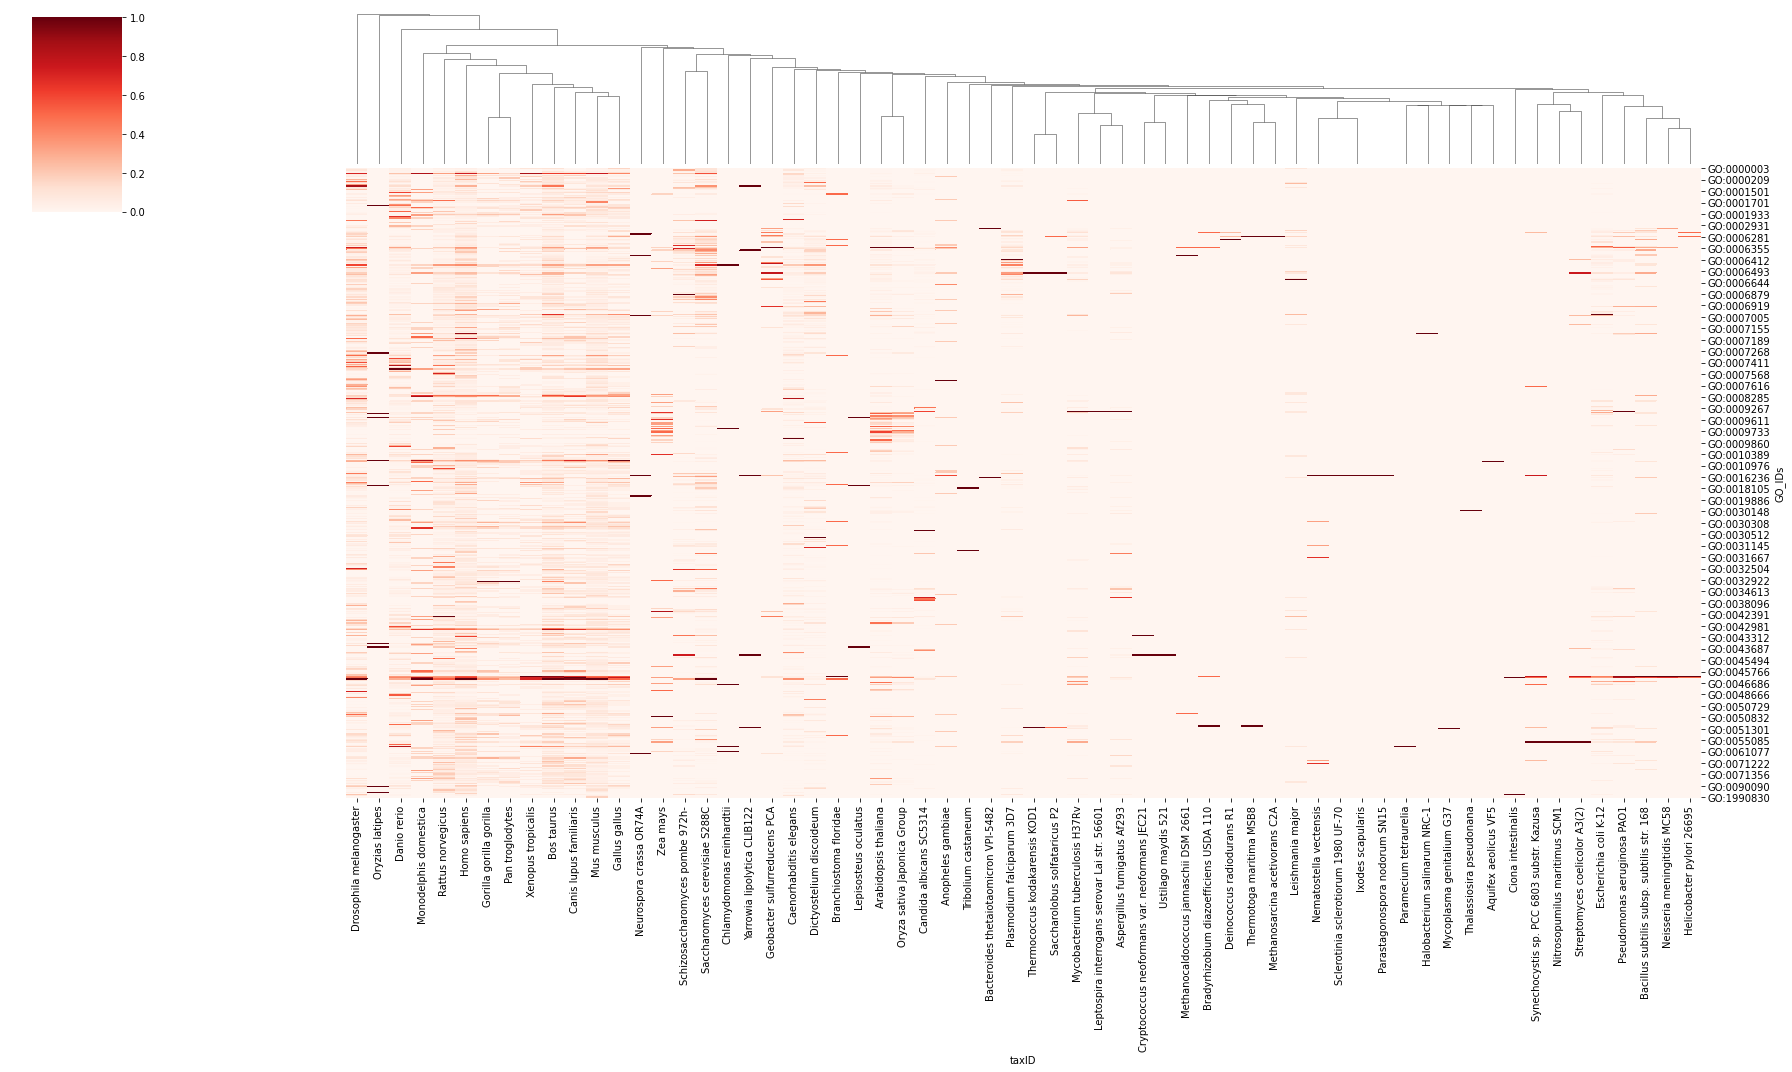

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

plot = sns.clustermap(GO_terms_distribution, 
               #method='complete', metric='hamming', 
               standard_scale=1, figsize=(25, 15), 
               row_cluster=False, col_cluster=True, 
               cmap="Reds",        # Other way sns.mpl_palette("reds",n_colors=2, as_cmap=True))
               xticklabels=1
               )
plot

### Interactive Heat Map

In [ ]:
# Scaling data with sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = MinMaxScaler()
GO_terms_distribution_scaled = pd.DataFrame(scaler.fit_transform(GO_terms_distribution.values), columns=GO_terms_distribution.columns, index=GO_terms_distribution.index)
GO_terms_distribution_scaled

taxID,Homo sapiens,Gorilla gorilla gorilla,Pan troglodytes,Mus musculus,Rattus norvegicus,Canis lupus familiaris,Bos taurus,Monodelphis domestica,Gallus gallus,Xenopus tropicalis,Ciona intestinalis,Branchiostoma floridae,Lepisosteus oculatus,Danio rerio,Oryzias latipes,Helobdella robusta,Nematostella vectensis,Caenorhabditis elegans,Monosiga brevicollis,Leishmania major,Ixodes scapularis,Dictyostelium discoideum,Batrachochytrium dendrobatidis JAM81,Chlamydomonas reinhardtii,Trichomonas vaginalis,Tribolium castaneum,Giardia lamblia ATCC 50803,Physcomitrium patens,Paramecium tetraurelia,Anopheles gambiae,Drosophila melanogaster,Thalassiosira pseudonana,Plasmodium falciparum 3D7,Phytophthora ramorum,Leptospira interrogans serovar Lai str. 56601,Fusobacterium nucleatum subsp. nucleatum ATCC 25586,Cryptococcus neoformans var. neoformans JEC21,Aquifex aeolicus VF5,Bacteroides thetaiotaomicron VPI-5482,Ustilago maydis 521,Thermotoga maritima MSB8,Schizosaccharomyces pombe 972h-,Thermodesulfovibrio yellowstonii DSM 11347,Puccinia graminis f. sp. tritici CRL 75-36-700-3,Dictyoglomus turgidum DSM 6724,Arabidopsis thaliana,Thermococcus kodakarensis KOD1,Neisseria meningitidis MC58,Bacillus subtilis subsp. subtilis str. 168,Bradyrhizobium diazoefficiens USDA 110,Rhodopirellula baltica SH 1,Deinococcus radiodurans R1,Methanocaldococcus jannaschii DSM 2661,Mycoplasma genitalium G37,Chlamydia trachomatis D/UW-3/CX,Saccharolobus solfataricus P2,Chloroflexus aurantiacus J-10-fl,Candidatus Korarchaeum cryptofilum OPF8,Nitrosopumilus maritimus SCM1,Zea mays,Oryza sativa Japonica Group,Halobacterium salinarum NRC-1,Mycobacterium tuberculosis H37Rv,Escherichia coli K-12,Helicobacter pylori 26695,Streptomyces coelicolor A3(2),Methanosarcina acetivorans C2A,Pseudomonas aeruginosa PAO1,Candida albicans SC5314,Geobacter sulfurreducens PCA,Gloeobacter violaceus PCC 7421,Yarrowia lipolytica CLIB122,Parastagonospora nodorum SN15,Aspergillus fumigatus Af293,Saccharomyces cerevisiae S288C,Synechocystis sp. PCC 6803 substr. Kazusa,Neurospora crassa OR74A,Sclerotinia sclerotiorum 1980 UF-70
GO_IDs,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
GO:0000003,0.001325,0.0,0.00,0.001364,0.004706,0.000000,0.000000,0.0,0.032258,0.000000,0.0,0.0,0.0,0.006452,0.0,0.0,0.0,0.347826,0.0,0.000000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.005051,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.008576,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0
GO:0000045,0.039735,0.0,0.05,0.042292,0.030588,0.000000,0.112903,0.0,0.161290,0.095238,0.0,0.0,0.0,0.032258,0.0,0.0,0.0,0.018116,0.0,0.083333,0.0,0.03125,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035354,0.0,0.010989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008621,0.0,0.0,0.0,0.003431,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.00000,0.102857,0.0,0.0,0.0
GO:0000070,0.021192,0.0,0.00,0.016371,0.011765,0.000000,0.016129,0.0,0.032258,0.000000,0.0,0.0,0.0,0.025806,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.01250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.101010,0.0,0.032967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.293103,0.0,0.0,0.0,0.006861,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.013624,0.0,0.0,0.0,0.0,0.00000,0.102857,0.0,0.0,0.0
GO:0000082,0.103311,0.0,0.00,0.046385,0.040000,0.043478,0.096774,0.0,0.032258,0.000000,0.0,0.0,0.0,0.019355,0.0,0.0,0.0,0.007246,0.0,0.000000,0.0,0.01250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.035354,0.0,0.010989,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.034483,0.0,0.0,0.0,0.005146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.010899,0.0,0.0,0.0,0.0,0.00000,0.125714,0.0,0.0,0.0
GO:0000086,0.154967,0.0,0.00,0.032742,0.023529,0.086957,0.080645,0.0,0.129032,0.000000,0.0,0.0,0.0,0.019355,0.0,0.0,0.0,0.000000,0.

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
                   z=GO_terms_distribution_scaled.values,
                   x=GO_terms_distribution_scaled.columns,
                   y=GO_terms_distribution_scaled.index,
                   hoverongaps = False,
                   colorscale='Reds',
                   colorbar= dict(title="Intensity")
                   ))
fig.update_layout(
    title='Go terms distribution',
)
fig.update_yaxes(title="GO terms")
fig.update_xaxes(type='category', title="Species")
fig.show()


# Machine Learning

## With single classification models


### Using only mitocondria annotated proteins

In [ ]:
# From MitoCarta v3 dataset (https://academic.oup.com/nar/article/44/D1/D1251/2502576#81915924)
with open("/content/drive/MyDrive/TFG/human_mitocarta_v3.txt", "r") as input:
    mitocarta = set(input.read().splitlines())
len(mitocarta)

1132

In [ ]:
# From the QuickGO web interface, by manually filtering by 9606 specie, Cellular Component GO Aspect, the respective experimental Evidence Codes and GO:0005739 (only "is_a" relationships)
mito_dataset_quickgo = pd.read_csv("/content/drive/MyDrive/TFG/QuickGO-annotations-C_aspect-GO0005739.tsv", sep="\t", header=0)
mito_proteins_quickgo = set(mito_dataset_quickgo["GENE PRODUCT ID"].tolist())
len(mito_proteins_quickgo)

1599

In [ ]:
# Datasets comparison
len(mitocarta.intersection(mito_proteins_quickgo))

661

In [ ]:
mitoproteins = mito_proteins_quickgo | mitocarta # Sets union
len(mitoproteins)

2070

In [ ]:
mitoproteins = set(profiling_matrix.explode("GO_IDs")[profiling_matrix.explode("GO_IDs")["GO_IDs"]=="GO:0044238"].index.get_level_values(1))

#### Prepare training dataset

In [ ]:
# Retrieve human Phylogenetic Matrix without GO terms
human_pp_matrix = profiling_matrix.loc[9606].drop(columns=["9606", "GO_IDs"], axis=1, errors='ignore')
human_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0
O76031,1,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,4,3,0,1,1,1,1,0,1,0,1,0,0,0,0,0,2,1,1,1,1,1,1,1,2,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
P00492,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,2,0,1,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P01714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q05315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q3LHN2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
Q701N2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


In [ ]:
# Add label column
human_pp_matrix["isMitochondrial"] = human_pp_matrix.index.map(lambda x: 1 if x in mitoproteins else 0)
human_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,isMitochondrial
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,1
Q14397,1,0,0,0,0,0,1,0,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,1,1,0,1,1,1,0,1,1,0,1,1,1,1,2,0,0,0,0,0,0,0,0,0,0
O76031,1,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,4,3,0,1,1,1,1,0,1,0,1,0,0,0,0,0,2,1,1,1,1,1,1,1,2,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
P00492,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,2,0,1,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
P01714,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q05315,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q3LHN2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
Q701N2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Differentiate positive and negative samples
positive_samples = human_pp_matrix[human_pp_matrix["isMitochondrial"]==1]
negative_samples = human_pp_matrix[human_pp_matrix["isMitochondrial"]==0]
positive_samples

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,isMitochondrial
Q96T66,1,0,1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,1,1,4,0,0,1,1,2,1,1,1,0,1,1,1,1,2,0,0,0,0,1,1,1,2,1,0,1,1,0,0,0,1,1,1,1,1,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,1,0,1
Q6IQ20,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,0,0,1,0,0,0,0,0,1,1,1,1,0,4,0,1,0,0,0,1,0,2,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,3,0,0,0,0,0,0,0,0,0,3,0,1
O76031,1,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,3,3,4,3,0,1,1,1,1,0,1,0,1,0,0,0,0,0,2,1,1,1,1,1,1,1,2,0,0,1,0,1,1,1,1,1,1,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,1
P00492,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,2,0,1,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,1
P22234,2,0,1,0,2,0,0,1,1,0,0,1,2,0,0,0,0,0,1,1,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,2,1,1,0,0,1,3,1,1,0,1,0,0,0,0,1,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q02505,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q6NZ36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
P06454,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
K9M1U5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Build training dataset from a combination of the positive and a determined number of negative samples.
training_matrix = pd.concat([positive_samples, negative_samples.sample(n=len(positive_samples))])
training_matrix = training_matrix.sample(frac=1) # Shuffle randomly
training_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,isMitochondrial
P51553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3,4,2,2,1,1,1,1,1,1,1,0,1,0,0,0,1,0,2,0,2,2,1,1,1,1,0,2,0,0,1,1,1,1,1,0,1,1,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,1,0,1
Q9ULM3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,1,0,1,1,1,0,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1
Q8TC07,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,0,0,0,0,1,0,0,0,0,0,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,1,0,0
Q96DW6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,1,1,1,1,1,0,0,0,1,0,0,0,1,3,0,1,1,1,0,0,0,1,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0
Q9Y2G3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2,0,1,0,0,1,2,0,1,0,0,0,1,1,1,1,1,1,0,1,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9NRY2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,1,1,1,1,2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
Q6VVX0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,44,15,0,0,0,0,0,0,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q6NUI2,1,0,1,0,1,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,1,1,1,1,1,0,1,1,1,0,0,1,0,1,1,1,1,1,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,1
P38570,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,1,0,1,1,1,1,0,0,0,0,0,0,2,3,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

X_training_matrix = training_matrix.iloc[:, :-1]
y_training_matrix = training_matrix.iloc[:, -1] # last column corresponds to "isMitochondrial" column

X_train, X_test, y_train, y_test = train_test_split(X_training_matrix, y_training_matrix, test_size=0.20)
X_train

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911
P42773,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q9NRE1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Q9NSD7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,1,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
O15551,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,2,2,1,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
P82970,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
O95935,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Q13356,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,1,1,1,0,1,0,0,0,1,0,0,1,1,2,1,1,0,1,1,0,1,0,0,1,1,1,1,1,1,1,1,1,0,0,1,0,1,2,0,1,0,0,0,0,0,0,0,0,0
Q14831,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,0,0,0,0,0,0,0,1,0,0,1,1,1,2,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
P55107,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,1,2,1,1,1,1,1,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Model selection

In [ ]:
# Support multilabel by default
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Does not support multilabel but multiclass does
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LinearRegression

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

#### Model training

In [ ]:
# With cross-validation
model = RandomForestClassifier()
cross_validate(model, X_train, y_train, cv=5, scoring=("accuracy", "precision", "recall", "roc_auc"), n_jobs=-1)

{'fit_time': array([1.88151741, 1.91532588, 1.87980437, 1.849684  , 1.17994881]),
 'score_time': array([0.18442917, 0.17335057, 0.17325282, 0.17306519, 0.13004375]),
 'test_accuracy': array([0.67156863, 0.66053922, 0.67830882, 0.66646229, 0.68976088]),
 'test_precision': array([0.66391509, 0.66624204, 0.67682927, 0.66033254, 0.68918919]),
 'test_recall': array([0.69164619, 0.64171779, 0.6809816 , 0.68304668, 0.68918919]),
 'test_roc_auc': array([0.71082012, 0.71200712, 0.73064106, 0.71367952, 0.74869406])}

In [ ]:
# Simple method (without cross-validation)
model = RandomForestClassifier().fit(X_train, y_train)
y_test_predictions = model.predict(X_test)
accuracy_score(y_test, y_test_predictions)

0.7710084033613446

#### Evaluate model

##### ROC curve

Credits: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

In [ ]:
# CALCULATE AUC SCORE

from sklearn.metrics import roc_auc_score

# generate a no skill prediction (majority class)
ns_probs = [0] * len(y_test)

# predict probabilities
real_probs = model.predict_proba(X_test)[:,1] # Only for the positive outcome (Mitochondrial in this case)

# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
real_auc = roc_auc_score(y_test, real_probs)
real_auc

0.8262348201451596

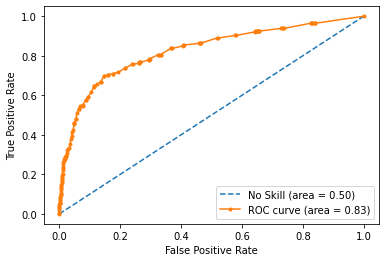

In [ ]:
# PLOT ROC CURVE

from sklearn.metrics import roc_curve
from matplotlib import pyplot

# Calculate False Negative and True Positive Rates
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
real_fpr, real_tpr, _ = roc_curve(y_test, real_probs)

# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill (area = %0.2f)' % ns_auc)
pyplot.plot(real_fpr, real_tpr, marker='.', label='ROC curve (area = %0.2f)' % real_auc)

pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
pyplot.legend()
pyplot.show()


##### Manually


In [ ]:
# Get all those proteins that were not used to train the model
test_pp_matrix = human_pp_matrix.drop(training_matrix.index) 
test_pp_matrix = test_pp_matrix.drop(columns="isMitochondrial")
test_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918
P00492,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,2,0,1,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,0
Q9HCR9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0
P16499,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,6,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
P25092,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
Q96CM4,2,0,0,0,0,0,1,0,2,0,0,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,12,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q701N2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Manually prediction test
test_pp_matrix["isMitocondrial_predictions"] = model.predict(test_pp_matrix)
test_pp_matrix

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitocondrial_predictions
P00492,1,0,1,1,1,0,1,1,1,1,0,1,1,1,0,0,2,0,1,0,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,1,1,1,1,0,0,1,1,0,1,1,1,0,0,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,0,0
Q9HCR9,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0
P16499,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,6,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,1,1,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
P25092,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,2,2,1,1,1,1,1,1,1,1,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Q96CM4,2,0,0,0,0,0,1,0,2,0,0,2,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,12,0,0,0,0,0,0,0,1,1,1,1,1,1,0,1,1,1,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q701N2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
M0R036,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
O14598,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
Q5T7P6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Revise predictions
test_pp_matrix[test_pp_matrix["isMitocondrial_predictions"]==1]

,189518,85962,208964,122586,83333,272561,226186,190304,324602,1111708,243230,224308,83332,100226,243273,243232,188937,64091,273057,243274,3055,3218,3702,39947,4577,284812,559292,284591,367110,665079,214684,237631,418459,237561,5664,5722,184922,36329,5888,6239,6412,6945,7070,7165,7227,7719,7739,7955,8090,8364,9031,9595,9598,9615,9913,10090,10116,13616,321614,289376,251221,35128,243231,44689,45351,224324,81824,684364,164328,243090,69014,436308,374847,515635,330879,224911,7918,isMitocondrial_predictions
P00966,1,0,1,0,1,0,1,0,1,1,1,1,1,1,0,1,1,1,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1,0,1
P26640,1,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,1,1,1,3,2,4,4,5,3,1,0,2,1,3,1,0,0,1,1,2,1,0,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,0,1,0,2,0,1,2,0,0,0,0,0,0,1,2,0,0,1
Q6P2I3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,1,2,1,1,1,1,0,0,0,1,1,1,1,1,1,0,0,0,1,0,1,1,0,1,0,0,1,0,0,0,0,0,0,0,1
Q9NRR4,1,1,1,1,1,1,0,1,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,0,1,0,0,0,0,0,1,2,2,1,1,1,1,1,1,1,0,1,1,1,2,1,1,1,1,1,0,1,0,1,1,1,0,1,0,0,0,0,0,0,0,1,0,0,1
Q8NBZ7,1,0,0,0,0,0,2,1,0,2,0,0,0,1,0,0,0,0,1,0,1,8,6,6,9,0,2,1,0,0,1,1,0,0,0,0,0,0,0,1,2,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,3,1,0,1,1,1,0,1,1,0,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9NSP4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,1,1,1,1,1,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Q9UI15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Q92844,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
P01282,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,2,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [ ]:
# Take only the indices
"\n".join(test_pp_matrix[test_pp_matrix["isMitocondrial_predictions"]==1].index)

'P00966\nP26640\nQ6P2I3\nQ9NRR4\nQ8NBZ7\nQ8WWH5\nQ06203\nP06132\nQ02880\nQ9Y450\nP15170\nO75874\nQ5SR56\nQ96MC6\nO75821\nQ99943\nO95757\nQ8IY17\nQ6ZV29\nP22102\nO14647\nP18283\nP19623\nO75792\nP49588\nP54577\nQ6ZMR3\nQ6IA69\nQ8TB92\nO60547\nQ7Z6V5\nP49903\nO60725\nQ15181\nP49441\nQ9H0R4\nP35520\nQ04446\nP00374\nO15067\nO00399\nP17844\nQ9HC07\nQ9NRZ7\nP10768\nP31350\nP54687\nP37837\nQ9BXU8\nQ9UJ83\nQ8TDQ7\nQ8WUX2\nQ9BUX1\nM0R2C6\nQ6P461\nA6NFU8\nQ9NXJ5\nQ9BT22\nP11387\nP10746\nQ01581\nQ8WZ04\nQ4AC99\nQ96C11\nF5H5T6\nQ9NR48\nQ14671\nP06744\nP60900\nQ9Y285\nP40616\nQ02833\nQ13387\nP82979\nQ9NX61\nP55157\nQ7Z6J2\nQ63HQ0\nQ96H22\nQ9NSP4\nQ9UI15\nQ92844\nP01282\nQ96QD9'

### Using Lowest Common Ancestor (LCA)

## With multi-label (multiple GO terms) classification models

### Prepare training dataset

In [111]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

training_matrix = profiling_matrix[profiling_matrix["GO_IDs"].str.len()>0]  # Filter out some proteins that may have remained without any annotation after passing through the ocurrences filter.

X_training_matrix = training_matrix.iloc[:, :-1]
y_training_matrix = training_matrix.iloc[:, -1:] # The last column corresponds to the GO_IDs

# We need to compute one-hot encoding for multilable classification as the models does not accept matrices with different shape.
mlb = MultiLabelBinarizer()
y_training_matrix_encoded = pd.DataFrame(mlb.fit_transform(y_training_matrix["GO_IDs"]), columns=mlb.classes_, index=y_training_matrix.index)

y_training_matrix_encoded = y_training_matrix_encoded[["GO:0071704", "GO:0008152", "GO:0071704", "GO:0044237"]]
y_training_matrix_encoded

GO:0071704  GO:0008152  GO:0071704  GO:0044237
9606 Q96T66           1           1           1           1
     Q6IQ20           1           1           1           1
     Q14397           1           1           1           1
     O76031           1           1           1           0
     P00492           1           1           1           1
...                 ...         ...         ...         ...
     P01714           0           0           0           0
     Q05315           0           0           0           0
     Q3LHN2           0           0           0           0
     Q701N2           0           0           0           0
     Q9UHF3           1           1           1           1

[13000 rows x 4 columns]

### Model selection

In [107]:
# Support multilabel by default
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

# Does not support multilabel but multiclass does
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.linear_model import RidgeClassifierCV
from sklearn.naive_bayes import MultinomialNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate


In [112]:
# Simple method (without cross-validation)
X_train, X_test, y_train, y_test = train_test_split(X_training_matrix, y_training_matrix_encoded, test_size=0.25)
model = RandomForestClassifier().fit(X_train, y_train)
y_test_predictions = model.predict(X_test)
accuracy_score(y_test, y_test_predictions)

0.6658461538461539

In [113]:
# With cross-validation
model = RandomForestClassifier()
cross_validate(model, X_train, y_train, cv=5, scoring=("accuracy", "roc_auc", "f1_macro"), n_jobs=1) # We could also choose only one scoring method

{'fit_time': array([1.95654917, 1.94529796, 1.92362738, 1.89828897, 1.9144485 ]),
 'score_time': array([0.23063946, 0.23394585, 0.2286191 , 0.22889256, 0.23706031]),
 'test_accuracy': array([0.66205128, 0.66512821, 0.66307692, 0.65128205, 0.65282051]),
 'test_f1_macro': array([0.64593464, 0.62995777, 0.64843937, 0.62477933, 0.61578326]),
 'test_roc_auc': array([0.75331296, 0.75712847, 0.76044434, 0.74666866, 0.74552434])}

In [ ]:
# From https://towardsdatascience.com/simple-way-to-find-a-suitable-algorithm-for-your-data-in-scikit-learn-python-9a9710c7c0fe

def create_baseline_classifiers(seed=8):
    """Create a list of baseline classifiers.
    
    Parameters
    ----------
    seed: (optional) An integer to set seed for reproducibility
    Returns
    -------
    A list containing tuple of model's name and object.
    """
    models = {}
    # Inherently multilabel
    models['Dummy'] = DummyClassifier(random_state=seed, strategy='prior')
    models['RandomForest'] = RandomForestClassifier(random_state=seed, n_jobs=1) # Random Forest consumes a lot of memory to be run in parallel
    models['KNN'] = KNeighborsClassifier(n_jobs=1)
    models['NeuralNetwork'] = MLPClassifier(random_state=seed)

    # No support for multilabel unless using OneVSRestClassifier or ClassifierChain
    models['SupportVectorMachine'] = OneVsRestClassifier(SVC(random_state=seed, probability=True), n_jobs=1)
    models['GradientBoosting'] = OneVsRestClassifier(GradientBoostingClassifier(random_state=seed), n_jobs=1)
    models['MultinomialNB'] = OneVsRestClassifier(MultinomialNB(), n_jobs=1)
    return models

def assess_models(X, y, models, cv=5, metrics=('accuracy','roc_auc', 'f1')):
    """Provide summary of cross validation results for models.
    
    Parameters
    ----------
    X: A pandas DataFrame containing feature matrix
    y: A pandas Series containing target vector
    models: A list of models to train
    cv: (optional) An integer to set number of folds in cross-validation
    metrics: (optional) A list of scoring metrics or a string for a metric
    Returns
    -------
    A pandas DataFrame containing summary of baseline models' performance.
    
    """
    summary = pd.DataFrame()
    for name, model in models.items():
        result = pd.DataFrame(cross_validate(model, X, y, cv=cv, scoring=metrics, n_jobs=-1))
        mean = result.mean().rename('{}_mean'.format)
        std = result.std().rename('{}_std'.format)
        summary[name] = pd.concat([mean, std], axis=0)
    return summary.sort_index()

### Models training

In [ ]:
models = create_baseline_classifiers()
summary = assess_models(X_train, y_train, models, metrics=("accuracy", "f1_macro"))
summary

,Dummy,RandomForest,KNN,NeuralNetwork,SupportVectorMachine,GradientBoosting,MultinomialNB
fit_time_mean,0.012070,6.066271,0.049460,9.410647,218.109081,59.386899,0.332783
fit_time_std,0.000399,0.467689,0.000491,1.205765,26.750227,3.315319,0.034970
score_time_mean,0.011875,0.613065,2.749094,0.017109,6.199454,0.256870,0.180541
score_time_std,0.000880,0.055037,0.228358,0.001353,0.242055,0.018800,0.013614
test_accuracy_mean,0.000000,0.032314,0.038468,0.033168,0.012139,0.035391,0.008206
test_accuracy_std,0.000000,0.002299,0.003578,0.007314,0.003795,0.003504,0.002057
test_f1_macro_mean,0.000000,0.106273,0.106140,0.112676,0.022425,0.131963,0.096278
test_f1_macro_std,0.000000,0.014950,0.014010,0.011316,0.003732,0.007767,0.004421


In [ ]:
summary.to_csv("results/MTP/MtP_201601_blasted-ML_asessment.tab")

### Model evaluation

In [40]:
predictions = pd.DataFrame(y_test_predictions, columns=y_test.columns, index=y_test.index)
predictions 

GO:0000226  GO:0001505  ...  GO:1901700  GO:1903047
9606 Q9UBD9           0           0  ...           0           0
     Q14166           0           0  ...           0           0
     O95249           0           0  ...           0           1
     Q92551           0           0  ...           0           0
     P50748           0           0  ...           0           0
...                 ...         ...  ...         ...         ...
     Q8N5Z5           0           0  ...           0           0
     P40763           0           0  ...           0           0
     P22102           0           0  ...           0           0
     P41161           0           0  ...           0           0
     Q969Z3           0           0  ...           0           0

[2912 rows x 208 columns]

In [11]:
probabilities = model.predict_proba(X_test)
probabilities = pd.DataFrame(probabilities, columns=y_test.columns, index=y_test.index)
probabilities

GO:0000226  GO:0001505  ...  GO:1901700  GO:1903047
9606 Q9UBD9        0.00        0.00  ...        0.00        0.00
     Q14166        0.01        0.00  ...        0.00        0.10
     O95249        0.01        0.01  ...        0.00        0.58
     Q92551        0.01        0.00  ...        0.06        0.04
     P50748        0.01        0.00  ...        0.04        0.01
...                 ...         ...  ...         ...         ...
     Q8N5Z5        0.00        0.01  ...        0.01        0.05
     P40763        0.02        0.00  ...        0.11        0.00
     P22102        0.09        0.19  ...        0.24        0.12
     P41161        0.02        0.00  ...        0.11        0.04
     Q969Z3        0.01        0.03  ...        0.06        0.05

[2912 rows x 208 columns]

In [55]:
probabilities.mean(axis=1).max()

0.20646634615384604

In [54]:
set(zip(y_test.loc[9606, "Q9H222"], y_test.columns)) - set(zip(predictions.loc[9606, "Q9H222"], y_test.columns))

{(0, 'GO:0032940'),
 (0, 'GO:0044249'),
 (1, 'GO:0003008'),
 (1, 'GO:0032501'),
 (1, 'GO:0032879'),
 (1, 'GO:0042592'),
 (1, 'GO:0051239'),
 (1, 'GO:0055085')}

In [56]:
from sklearn.metrics import accuracy_score

accuracy_score(y_test.loc[9606, "Q9H222"], predictions.loc[9606, "Q9H222"])

0.9615384615384616

# Deprecated cells

In [ ]:
# Wrong way of performing one hot encoding 
import pandas
y_training_matrix_one_hot_encoded = pd.get_dummies(y_training_matrix["GO_IDs"].explode(), 
                                                   prefix="", prefix_sep=""
                                                   ).reset_index().groupby("index").first() # We take the first ocurrence as they all must be the same (no matter the first, last or whatever)


In [ ]:
# 1st version of the PP matrix (without GO terms)
# We need to assign GO terms to profiling matrix
import json
import pandas as pd
profiling_matrix = getOrthologsPresenceMatrix()
with open("drive/MyDrive/TFG/human_genes2GOtermIDs.json", "r") as input:
    human_gene2GOterms = json.load(input)
profiling_matrix["GO_IDs"] = profiling_matrix.index.map(lambda x: np.array(human_gene2GOterms.get(x)) if human_gene2GOterms.get(x) else [])